# Optimización Bayesiana

En este notebook se muestra la obtención de hiperparámetros óptimos para una red neuronal utilizando optimización bayesiana. Esta técnica es más eficiente que un Gridsearch o Manual tuning para casos (como el actual) en el que no se tienen recursos para realizar entrenamientos en paralelo de modelos.


https://arxiv.org/pdf/1807.02811.pdf

**NOTA:** Este notebook está ejecutado en *Google Colab*

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!pip install --upgrade pandas
!pip install --upgrade matplotlib==2.1.1
!pip install scikit-optimize

Requirement already up-to-date: pandas in /usr/local/lib/python3.6/dist-packages (0.24.2)
     |████████████████████████████████| 15.0MB 3.3MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.
  Found existing installation: matplotlib 3.0.3
    Uninstalling matplotlib-3.0.3:
      Successfully uninstalled matplotlib-3.0.3


     |████████████████████████████████| 81kB 3.6MB/s 


In [3]:
!ls "drive/My Drive/Colab Notebooks/data"

data_kaggle_proc.pickle		       news_getting_real.pickle
GoogleNews-vectors-negative300.bin.gz  news_proc_12_3_19.pickle


# Imports, loads and Train/test split
---

In [6]:
import pandas as pd
import numpy as np

#Progress bars
from tqdm import tqdm
tqdm.pandas()

#Paralelize pandas apply on multiple cores
#import swifter

from matplotlib import pyplot as plt
from matplotlib import style
#Nicer style
style.use('seaborn-v0_8')
import seaborn as sns

from tensorflow import keras as k

from sklearn.model_selection import train_test_split

from gensim.models import KeyedVectors

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [8]:
data = pd.read_pickle('../data/news_proc_12_3_19.pickle')#.reset_index()
data = data.dropna()

Labels asignadas a los tipos

In [9]:
types = data['type'].unique()
for t in types:
    print("{} - {}".format(t, data[data['type'] == t].head(1)['one_hot_label'].iloc[0]))

truth - [1]
fake - [0]


In [10]:
len_content = len(data['content'][0])
len_title = len(data['title'][0])

print("Max len content: {}".format(len_content))
print("Max len title: {}".format(len_title))

Max len content: 1590
Max len title: 13


In [11]:
model = KeyedVectors.load_word2vec_format("../data/GoogleNews-vectors-negative300.bin.gz", binary=True, limit=50000)

In [15]:
embed_mat = np.zeros((50000,300))
for i, e in model.key_to_index.items():
    embed_mat[e] = model[i]

**Tran/valid/test split**

In [16]:
#Train - test
X_train, X_test, y_train, y_test = train_test_split(
    data[['content', 'title']], data['one_hot_label'], test_size=0.3, random_state=1)

#Train - valid
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.3, random_state=1)

In [17]:
X_train_title = X_train['title']
X_train_content = X_train['content']

X_valid_title = X_valid['title']
X_valid_content = X_valid['content']

X_test_title = X_test['title']
X_test_content = X_test['content']

In [18]:
train_fit = [np.asarray(X_train_title.tolist()), 
             np.asarray(X_train_content.tolist())]

valid_fit = [np.asarray(X_valid_title.tolist()), 
             np.asarray(X_valid_content.tolist())]

test_fit = [np.asarray(X_test_title.tolist()), 
             np.asarray(X_test_content.tolist())]

In [19]:
del data
del X_train_title, X_train_content
del X_valid_title, X_valid_content
del X_test_title, X_test_content

In [22]:
import skopt
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt.plots import plot_objective

from numpy.random import seed
# from tensorflow import set_random_seed

import tensorflow as tf

import os

# Finding optimal hyperparameters for the CNN

In [28]:
space  = [Real(1e-3, 0.4, name='learning rate'),
          Real(1e-3, 0.4, name='momentum'),
          Real(1e-3, 0.4, name='dropout1'),
          Real(1e-3, 0.4, name='dropout2'),
          Integer(5,15, name='filters1Title'),
          Integer(25,60, name='denseTitle'),
          Integer(5,15, name='filtersContent'),
          Integer(25,60, name='denseContent') ]

In [33]:
@use_named_args(space)
def cnn_model(**params):
    
    x_train = train_fit
    y_train2 = np.array(y_train.tolist())
    
    x_valid = valid_fit
    y_valid2 = np.array(y_valid.tolist())
    
    x_test = test_fit
    y_test2 = np.array(y_test.tolist())

    #Reproducible
    seed(50)
    tf.random.set_seed(50)
    k.backend.clear_session()
    
    
    
    #input_title
    title_input = k.layers.Input(shape=(len_title,), name='title_input')
    inp = k.layers.Embedding(output_dim=300, input_dim=50000, 
                             weights=[embed_mat], trainable=False, name='embed_title')(title_input)

    x = k.layers.Conv1D(filters = params['filters1Title'], kernel_size=4, strides=2, activation='relu', name='Conv1Title')(inp)
    x = k.layers.MaxPool1D(pool_size = 2, name='Pool1Title')(x)
    x = k.layers.Flatten()(x)
    x = k.layers.Dense(params['denseTitle'], activation='relu', name='Dense1Title', kernel_regularizer='l2')(x)

    #input_content
    content_input = k.layers.Input(shape=(len_content,), name='content_input')
    inp2 = k.layers.Embedding(output_dim=300, input_dim=50000, 
                             weights=[embed_mat], trainable=False, name='embed_content')(content_input)
    x2 = k.layers.Conv1D(filters = params['filtersContent'], kernel_size = 16, strides = 2, activation='relu', name='Conv1Content')(inp2)
    x2 = k.layers.MaxPool1D(pool_size = 6, name='Pool1Content')(x2)
    
    x2 = k.layers.Conv1D(filters = 80, kernel_size = 8, strides = 4, activation='relu', name='Conv2Content')(inp2)
    x2 = k.layers.MaxPool1D(pool_size = 2, name='Pool2Content')(x2)

    x2 = k.layers.Flatten()(x2)
    x2 = k.layers.Dense(params['denseContent'], activation='relu', kernel_regularizer='l2', name='Dense1Content')(x2)


    #Merge
    x = k.layers.concatenate([x, x2])

    #Common part
    x = k.layers.Dense(100, activation='relu')(x)
    x = k.layers.Dropout(params['dropout1'])(x)
    x = k.layers.Dense(50, activation='relu')(x)
    x = k.layers.Dropout(params['dropout2'])(x)
    out = k.layers.Dense(1, activation='sigmoid')(x)


    #Build model
    model = k.models.Model(inputs=[title_input, content_input], outputs=[out])

    model.compile(k.optimizers.SGD(learning_rate=params['learning rate'], momentum=params['momentum']), loss='binary_crossentropy', metrics=['acc'])
    
    out = model.fit(x=x_train, y=y_train2, batch_size=128, epochs=20,
          callbacks = [k.callbacks.EarlyStopping(monitor='val_acc', patience=2, min_delta = 0.1)], 
                    validation_data=(x_valid, y_valid2))
    
    
    #Evaluation
    
    acc = model.evaluate(x=x_test, y=y_test2)
    return -acc[1] #Maximize accuracy

In [34]:
r = skopt.gp_minimize(cnn_model, n_random_starts=3, n_calls=5, dimensions=space)

Epoch 1/20


E:\anaconda3\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['title_input', 'content_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


451/451 ━━━━━━━━━━━━━━━━━━━━ 236s 510ms/step - acc: 0.7466 - loss: 1.2298 - val_acc: 0.9104 - val_loss: 0.5643
Epoch 2/20
451/451 ━━━━━━━━━━━━━━━━━━━━ 236s 523ms/step - acc: 0.9203 - loss: 0.4674 - val_acc: 0.9320 - val_loss: 0.3007
Epoch 3/20
451/451 ━━━━━━━━━━━━━━━━━━━━ 231s 512ms/step - acc: 0.9393 - loss: 0.2641 - val_acc: 0.9358 - val_loss: 0.2157
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 47s 43ms/step - acc: 0.9365 - loss: 0.2141
Epoch 1/20
451/451 ━━━━━━━━━━━━━━━━━━━━ 224s 489ms/step - acc: 0.8259 - loss: 1.0075 - val_acc: 0.9202 - val_loss: 0.2246
Epoch 2/20
451/451 ━━━━━━━━━━━━━━━━━━━━ 220s 487ms/step - acc: 0.9364 - loss: 0.1809 - val_acc: 0.9410 - val_loss: 0.1579
Epoch 3/20
451/451 ━━━━━━━━━━━━━━━━━━━━ 217s 482ms/step - acc: 0.9516 - loss: 0.1462 - val_acc: 0.9391 - val_loss: 0.1700
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 47s 43ms/step - acc: 0.9405 - loss: 0.1674
Epoch 1/20
451/451 ━━━━━━━━━━━━━━━━━━━━ 222s 489ms/step - acc: 0.8421 - loss: 0.9976 - val_acc: 0.9202 - val_loss: 0.2250
Epoch 2/2

E:\anaconda3\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['title_input', 'content_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


451/451 ━━━━━━━━━━━━━━━━━━━━ 230s 505ms/step - acc: 0.8385 - loss: 0.6738 - val_acc: 0.9275 - val_loss: 0.1872
Epoch 2/20
451/451 ━━━━━━━━━━━━━━━━━━━━ 215s 477ms/step - acc: 0.9376 - loss: 0.1683 - val_acc: 0.9405 - val_loss: 0.1638
Epoch 3/20
451/451 ━━━━━━━━━━━━━━━━━━━━ 214s 475ms/step - acc: 0.9548 - loss: 0.1435 - val_acc: 0.9368 - val_loss: 0.1821
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 45s 41ms/step - acc: 0.9374 - loss: 0.1804
Epoch 1/20


E:\anaconda3\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['title_input', 'content_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


451/451 ━━━━━━━━━━━━━━━━━━━━ 219s 482ms/step - acc: 0.8452 - loss: 0.9942 - val_acc: 0.9222 - val_loss: 0.2007
Epoch 2/20
451/451 ━━━━━━━━━━━━━━━━━━━━ 221s 490ms/step - acc: 0.9387 - loss: 0.1719 - val_acc: 0.9350 - val_loss: 0.1682
Epoch 3/20
451/451 ━━━━━━━━━━━━━━━━━━━━ 301s 667ms/step - acc: 0.9536 - loss: 0.1453 - val_acc: 0.9431 - val_loss: 0.1661
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 61s 55ms/step - acc: 0.9455 - loss: 0.1634


We can access the parameters with which the minimum is obtained in the loss function (maximum in our case)

In [35]:
print("PARAMETERS: {}  RESULT {}".format(r.x, r.fun))

PARAMETERS: [0.2165058962234678, 0.17315207003770283, 0.03535823654126957, 0.34342621903381093, 10, 58, 10, 57]  RESULT -0.9453643560409546


As we see, with these parameters an accuracy of 0.81 is obtained in the validation set.

<Axes: >

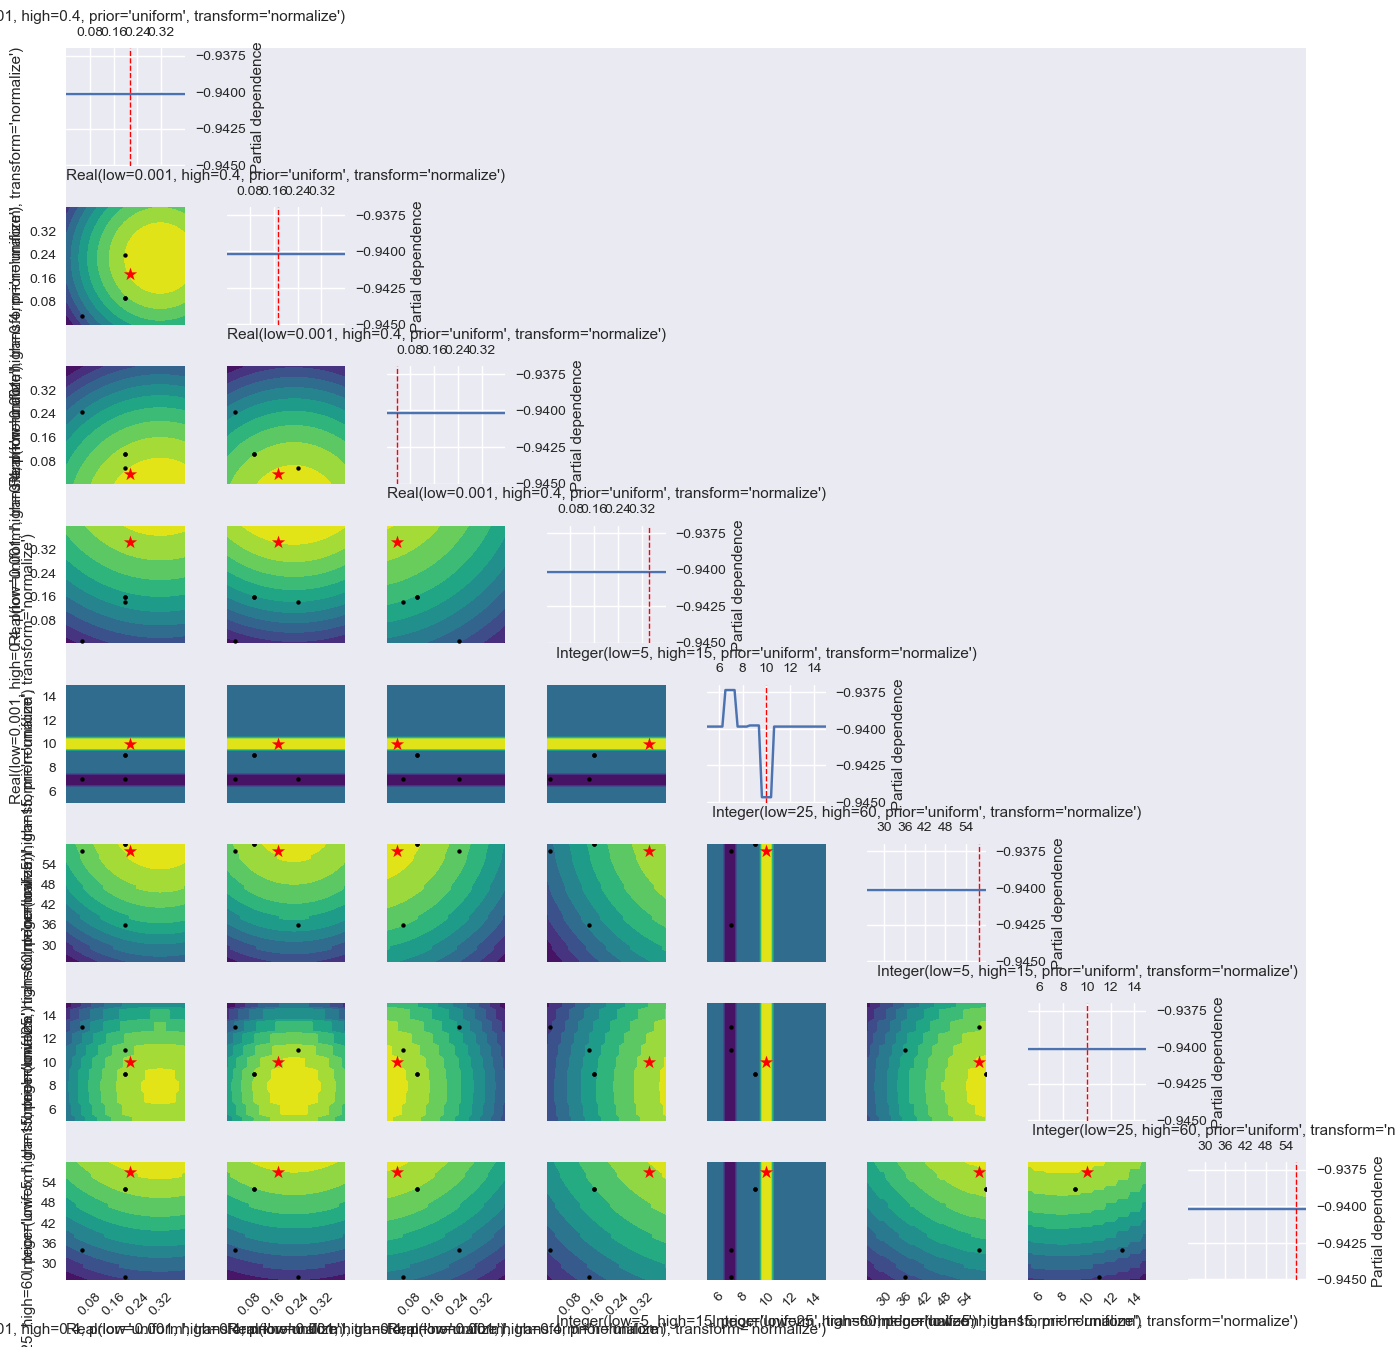

In [36]:
plot_objective(r, dimensions=space)

In [37]:
print("Params")
r.x_iters

Params


[[0.05254065915946037,
  0.03067626633445987,
  0.24436531496149036,
  0.009553056631600266,
  7,
  58,
  13,
  34],
 [0.1983460565696706,
  0.09200515867528518,
  0.10293409557912736,
  0.15913563397938804,
  9,
  60,
  9,
  52],
 [0.1983460565696706,
  0.09200515867528518,
  0.10293409557912736,
  0.15913563397938804,
  9,
  60,
  9,
  52],
 [0.1983460565696706,
  0.23973666796647666,
  0.05568005505589395,
  0.1407149663364295,
  7,
  36,
  11,
  26],
 [0.2165058962234678,
  0.17315207003770283,
  0.03535823654126957,
  0.34342621903381093,
  10,
  58,
  10,
  57]]

In [38]:
print("Values")
r.func_vals

Values


array([-0.93714207, -0.94096965, -0.93855971, -0.93719876, -0.94536436])

In [ ]:
space  = [Real(1e-3, 0.4, name='lr'),
          Real(1e-3, 0.1, name='momentum'),
          Real(0.1, 0.3, name='dropout1'),
          Integer(50,100, name='dense1'),
          Integer(20,50, name='dense2'),
          Integer(20,100, name='lstmTitle'),
          Integer(50,300, name='lstmContent')]


@use_named_args(space)
def lstm_model(**params):
    
    x_train = train_fit
    y_train2 = np.array(y_train.tolist())
    
    x_valid = valid_fit
    y_valid2 = np.array(y_valid.tolist())
    
    x_test = test_fit
    y_test2 = np.array(y_test.tolist())

    #Reproducible weights
    seed(50)
    set_random_seed(50)
    k.backend.clear_session()
    
    
    

    #input_title
    title_input = k.layers.Input(shape=(len_title,), name='title_input')
    inp = k.layers.Embedding(output_dim=300, input_dim=50000, 
                             weights=[embed_mat], trainable=False)(title_input)
    x = k.layers.Bidirectional(k.layers.LSTM(params['lstmTitle']))(inp)
    #CudnnLSTM

    #input_content
    content_input = k.layers.Input(shape=(len_content,), name='content_input')
    inp2 = k.layers.Embedding(output_dim=300, input_dim=50000, 
                             weights=[embed_mat], trainable=False)(content_input)
    x2 = k.layers.Bidirectional(k.layers.LSTM(params['lstmContent']))(inp2)
    #CudnnLSTM

    #Merge
    x = k.layers.concatenate([x, x2])


    #Common part
    x = k.layers.Dense(params['dense1'], activation='relu')(x)
    x = k.layers.Dropout(params['dropout1'])(x)
    x = k.layers.Dense(params['dense2'], activation='relu')(x)
    x = k.layers.Dropout(0.2)(x)

    out = k.layers.Dense(4, activation='softmax')(x)

    #Build model
    model = k.models.Model(inputs=[title_input, content_input], outputs=[out])

    #model.compile(k.optimizers.SGD(), loss='categorical_crossentropy', metrics=['acc'])
    model.compile(tf.train.MomentumOptimizer(learning_rate=params['lr'], momentum=params['momentum']), 
                  loss='categorical_crossentropy', metrics=['acc'])

    
    
    
    
    #Optimize TPU
    # This address identifies the TPU we'll use when configuring TensorFlow.
    TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']
    tf.logging.set_verbosity(tf.logging.INFO)

    tpu_model = tf.contrib.tpu.keras_to_tpu_model(
        model,
        strategy=tf.contrib.tpu.TPUDistributionStrategy(
            tf.contrib.cluster_resolver.TPUClusterResolver(TPU_WORKER)))



    
    out = tpu_model.fit(x=train_fit, y=np.asarray(y_train.tolist()), batch_size=64*8, epochs=30,
          callbacks = [k.callbacks.EarlyStopping(monitor='val_acc', patience=2, min_delta = 0.1)], 
                         validation_data=(valid_fit, np.array(y_valid.tolist())))
    

    
    
    #Evaluation
    acc = tpu_model.evaluate(x=x_test, y=y_test2)
    return -acc[1] #Maximize accuracy

In [16]:
r = skopt.gp_minimize(lstm_model, n_random_starts=3, n_calls=5, dimensions=space)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

INFO:tensorflow:Querying Tensorflow master (grpc://10.120.214.154:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 10182065026619425116)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 624929692778327347)
INFO:tensorflow:*** Available Device: _DeviceAt

In [17]:
print("PARAMETERS (LR/Optimizer): {}  RESULT {}".format(r.x, r.fun))

PARAMETERS (LR/Optimizer): [0.2639850638741692, 0.08255873365806747, 0.10591561319817788, 73, 24, 46, 231]  RESULT -0.7371156215667725


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5902fe8128>,
      dtype=object)

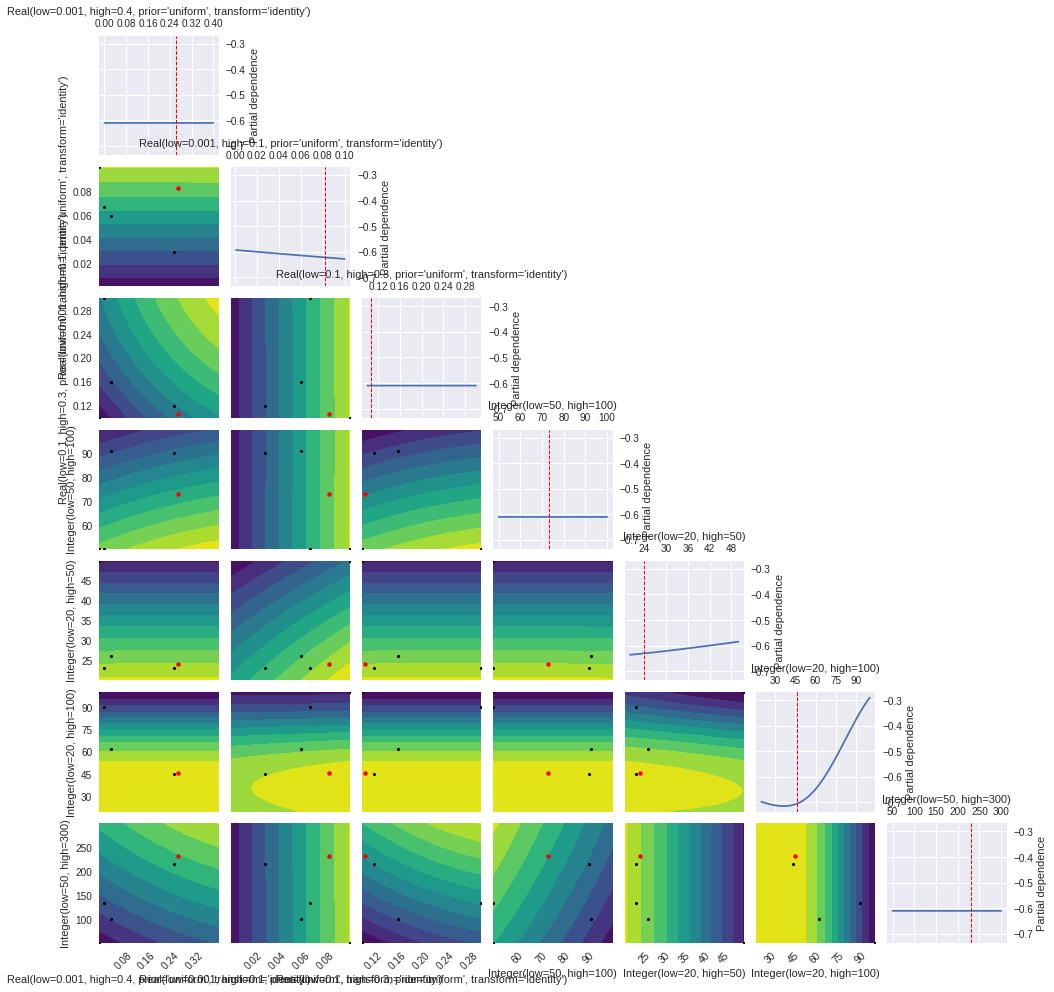

In [18]:
plot_objective(r, dimensions=space)